In [1]:
import importlib # reloading for my lib during the changes -  (yu don't need to restart the kernel)
import gc
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models.detection as detection

# Optional: Reload if needed (for interactive development)
import Utils.load_data
import Utils.training
import Utils.plot
importlib.reload(Utils.load_data)
importlib.reload(Utils.training)
importlib.reload(Utils.plot)
# Clear GPU cache
# Import from Utils modules
from Utils.load_data import *
from Utils.plot import *
from Utils.training import *


gc.collect() #free RAM - garbage collector 
torch.cuda.empty_cache() 

In [2]:
# Pascal VOC 2012 colormap (21 classes)
VOC_COLORMAP = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], 
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], 
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], 
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
], dtype=np.uint8)
# Initialize dataset (Assume color_map is already defined)
dataset = VocDataset(dir="data", color_map=VOC_COLORMAP, resize_dim=(320, 320), transform=None)
train_set,val_set=torch.utils.data.random_split(dataset,[int(len(dataset)*0.8),int(len(dataset)*0.2)+1])
train_loader=DataLoader(train_set,batch_size=8,num_workers=48,shuffle=True)
val_loader=DataLoader(val_set,batch_size=8,num_workers=48,shuffle=False)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


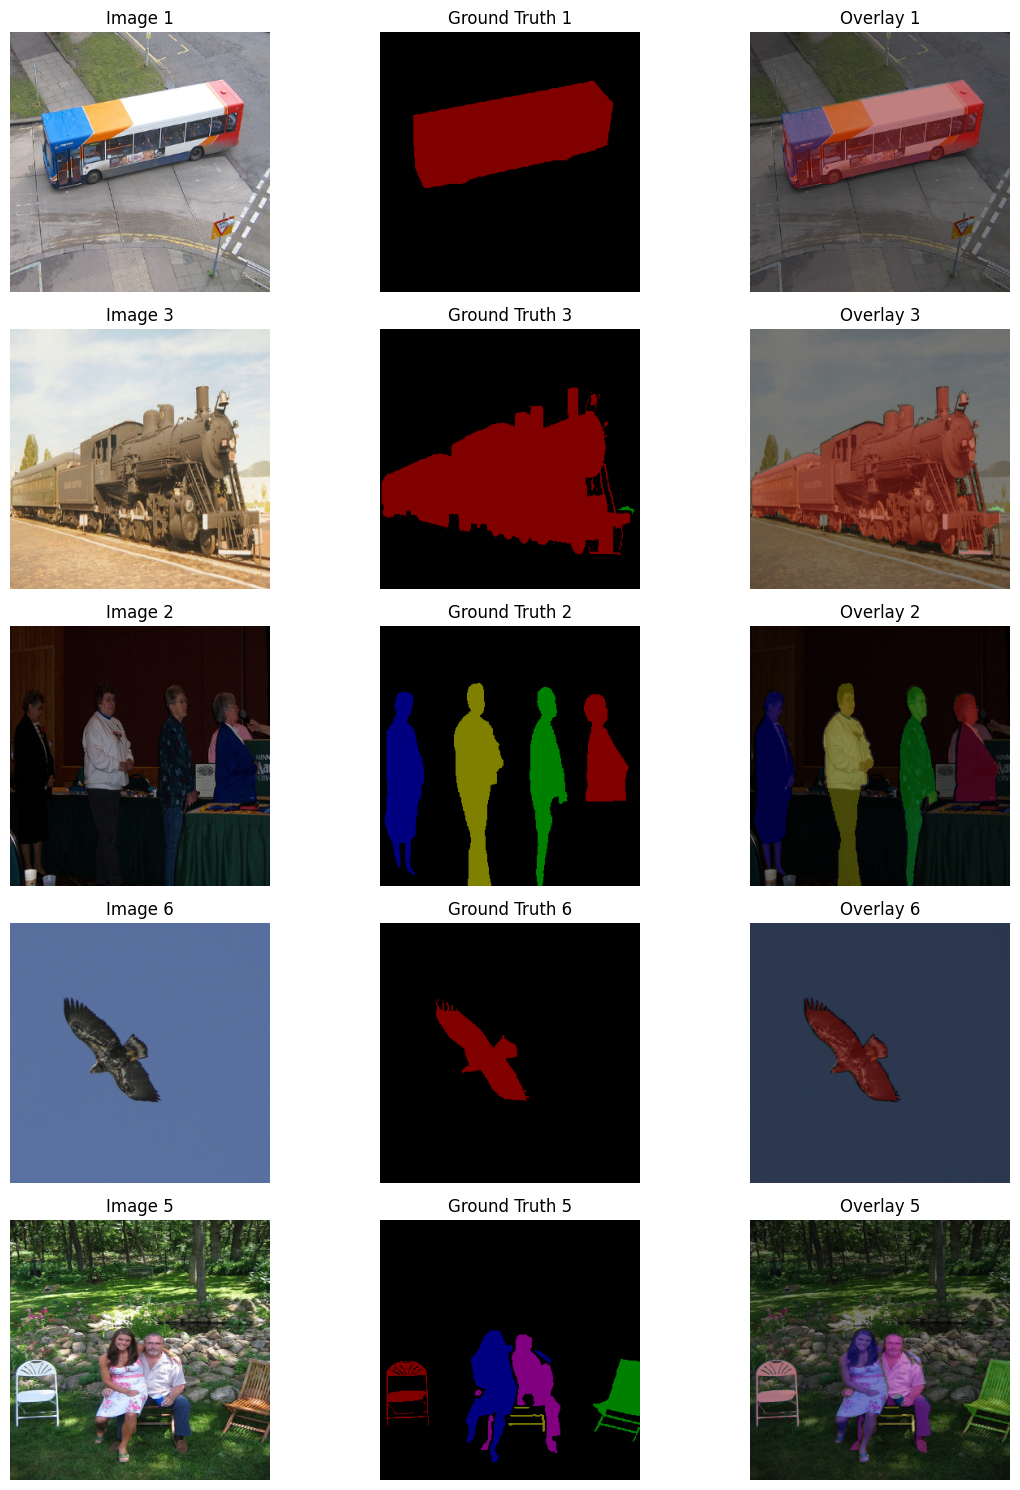

In [3]:
visualize_samples_seg(train_loader, num_samples=5, model=None, device="cuda")

In [6]:
import segmentation_models_pytorch as smp
import torch
from torch import optim
import segmentation_models_pytorch.losses as smp_losses

class SegmentationLoss(torch.nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super().__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.dice_loss = smp.losses.DiceLoss(mode='multilabel', from_logits=True)
        self.ce_loss = torch.nn.BCEWithLogitsLoss()

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        ce = self.ce_loss(y_pred, y_true)
        return self.weight_dice * dice + self.weight_ce * ce


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet101",  
    encoder_weights="imagenet",  # Use pre-trained weights
    in_channels=3,  # 3-channel RGB images
    classes=21, 
    activation="softmax"# Pascal VOC has 21 classes
).to(device)


# Initialize loss
criterion = SegmentationLoss(weight_dice=0, weight_ce=0.5)

# Optimizer with better initial learning rate
optimizer = optim.AdamW(model.parameters(), 
                       lr=1e-4,  # Lower initial learning rate
                       weight_decay=1e-4)  # Add weight decay
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=3,
)



In [7]:
train_history, test_history = train_model_seg(model, train_loader, val_loader, criterion, optimizer, scheduler, device, 10)

Testing: 100%|██████████| 73/73 [00:14<00:00,  5.12it/s, loss=0.3457]



Epoch 1/10
Train Loss: 0.3506
Test Loss: 0.3451

Training Metrics:
iou_score: 0.3983
f1_score: 0.4931
f2_score: 0.4573
accuracy: 0.9703
recall: 0.4393

Test Metrics:
iou_score: 0.6591
f1_score: 0.7691
f2_score: 0.7603
accuracy: 0.9804
recall: 0.7560

Saved best model with loss: 0.6591
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:14<00:00,  5.18it/s, loss=0.3431]



Epoch 2/10
Train Loss: 0.3434
Test Loss: 0.3427

Training Metrics:
iou_score: 0.7113
f1_score: 0.8074
f2_score: 0.8130
accuracy: 0.9829
recall: 0.8179

Test Metrics:
iou_score: 0.7223
f1_score: 0.8159
f2_score: 0.8270
accuracy: 0.9833
recall: 0.8359

Saved best model with loss: 0.7223
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:14<00:00,  5.19it/s, loss=0.3423]



Epoch 3/10
Train Loss: 0.3425
Test Loss: 0.3424

Training Metrics:
iou_score: 0.7325
f1_score: 0.8227
f2_score: 0.8347
accuracy: 0.9839
recall: 0.8440

Test Metrics:
iou_score: 0.7314
f1_score: 0.8231
f2_score: 0.8356
accuracy: 0.9839
recall: 0.8455

Saved best model with loss: 0.7314
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:14<00:00,  5.17it/s, loss=0.3428]



Epoch 4/10
Train Loss: 0.3423
Test Loss: 0.3424

Training Metrics:
iou_score: 0.7346
f1_score: 0.8244
f2_score: 0.8367
accuracy: 0.9841
recall: 0.8462

Test Metrics:
iou_score: 0.7270
f1_score: 0.8203
f2_score: 0.8324
accuracy: 0.9836
recall: 0.8420
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:13<00:00,  5.28it/s, loss=0.3423]



Epoch 5/10
Train Loss: 0.3419
Test Loss: 0.3423

Training Metrics:
iou_score: 0.7561
f1_score: 0.8396
f2_score: 0.8520
accuracy: 0.9855
recall: 0.8615

Test Metrics:
iou_score: 0.7296
f1_score: 0.8216
f2_score: 0.8344
accuracy: 0.9837
recall: 0.8445
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:14<00:00,  5.19it/s, loss=0.3421]



Epoch 6/10
Train Loss: 0.3416
Test Loss: 0.3422

Training Metrics:
iou_score: 0.7773
f1_score: 0.8544
f2_score: 0.8672
accuracy: 0.9869
recall: 0.8770

Test Metrics:
iou_score: 0.7356
f1_score: 0.8252
f2_score: 0.8361
accuracy: 0.9842
recall: 0.8448

Saved best model with loss: 0.7356
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:14<00:00,  5.21it/s, loss=0.3421]



Epoch 7/10
Train Loss: 0.3414
Test Loss: 0.3421

Training Metrics:
iou_score: 0.7868
f1_score: 0.8612
f2_score: 0.8732
accuracy: 0.9876
recall: 0.8825

Test Metrics:
iou_score: 0.7429
f1_score: 0.8306
f2_score: 0.8400
accuracy: 0.9849
recall: 0.8477

Saved best model with loss: 0.7429
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:14<00:00,  5.12it/s, loss=0.3423]



Epoch 8/10
Train Loss: 0.3413
Test Loss: 0.3420

Training Metrics:
iou_score: 0.7932
f1_score: 0.8659
f2_score: 0.8773
accuracy: 0.9881
recall: 0.8862

Test Metrics:
iou_score: 0.7527
f1_score: 0.8374
f2_score: 0.8469
accuracy: 0.9855
recall: 0.8546

Saved best model with loss: 0.7527
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:13<00:00,  5.23it/s, loss=0.3424]



Epoch 9/10
Train Loss: 0.3413
Test Loss: 0.3421

Training Metrics:
iou_score: 0.7966
f1_score: 0.8683
f2_score: 0.8793
accuracy: 0.9883
recall: 0.8880

Test Metrics:
iou_score: 0.7438
f1_score: 0.8314
f2_score: 0.8416
accuracy: 0.9849
recall: 0.8498
------------------------------------------------------------


Testing: 100%|██████████| 73/73 [00:13<00:00,  5.23it/s, loss=0.3424]



Epoch 10/10
Train Loss: 0.3412
Test Loss: 0.3421

Training Metrics:
iou_score: 0.8008
f1_score: 0.8713
f2_score: 0.8819
accuracy: 0.9887
recall: 0.8903

Test Metrics:
iou_score: 0.7421
f1_score: 0.8301
f2_score: 0.8393
accuracy: 0.9848
recall: 0.8468
------------------------------------------------------------


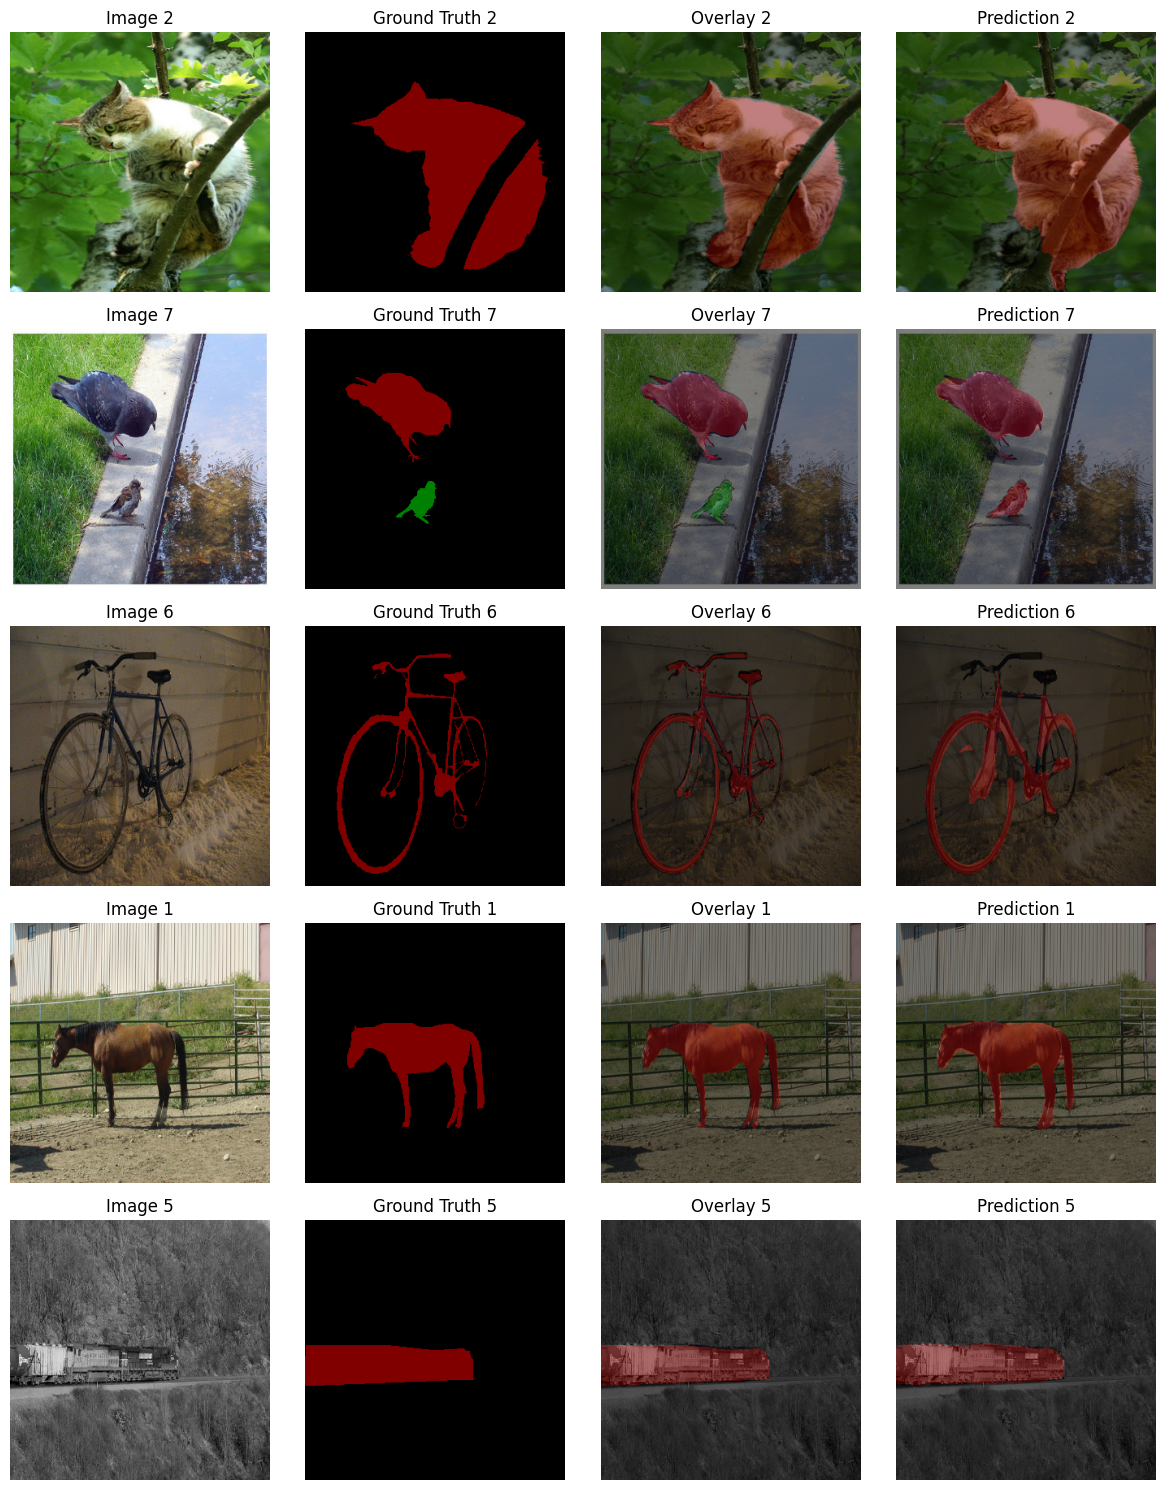

In [8]:
visualize_samples_seg(train_loader, num_samples=5, model=model, device="cuda")

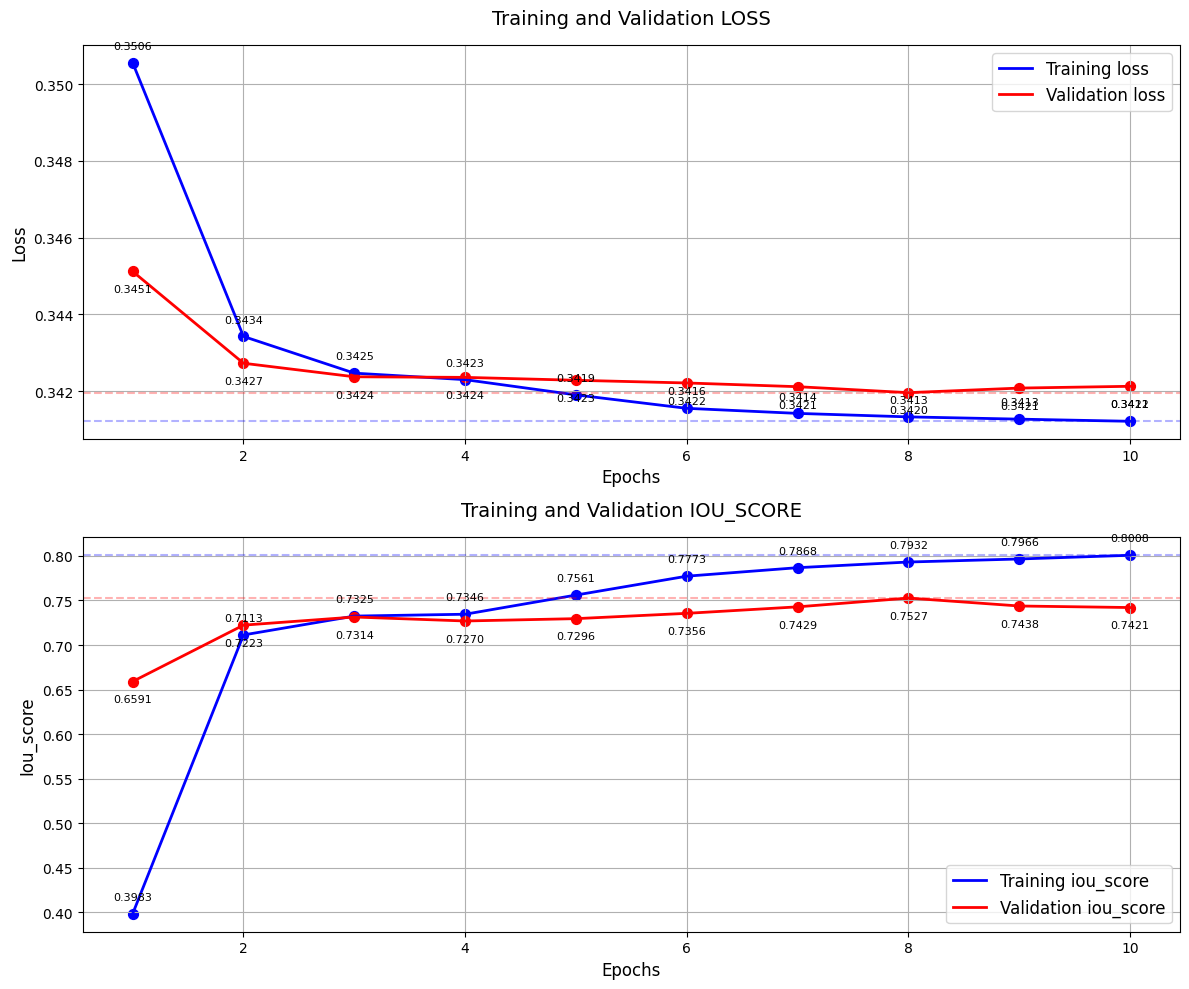

In [9]:
plot_detailed_history(
        train_history, 
        test_history, 
        metrics_to_plot=['loss', 'iou_score']
         )

